In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import *

from IPython.display import clear_output

In [2]:
sensor_id = -1408237098

directory_path = '../pos_tables/{}'.format(sensor_id)

path = '../results/convergence_analysis'
os.makedirs(path, exist_ok=True)

# List all files in the directory
files = os.listdir(directory_path)

df_list = []

i = 0
# Iterate through the files and read each one
for file_name in files:
    if(file_name != '.DS_Store'):
        file_path = os.path.join(directory_path, file_name)
        df_list.append(pd.read_csv(file_path))

## Get receiver lat, lon

In [4]:
df_sensors = pd.read_json('file:///Users/mfrahman/Python/adsb_reception_prob_model/sensors/sensor_list.json')

df_sensors['position'] = df_sensors['position'].apply(dict)

df_sensors['lat'] = df_sensors['position'].apply(lambda x: x['latitude'])
df_sensors['lon'] = df_sensors['position'].apply(lambda x: x['longitude'])
df_sensors['alt'] = df_sensors['position'].apply(lambda x: x['altitude'])

lat_receiver = df_sensors[df_sensors['serial'] == sensor_id]['lat']
lon_receiver = df_sensors[df_sensors['serial'] == sensor_id]['lon']
alt_receiver = df_sensors[df_sensors['serial'] == sensor_id]['alt']

## Define Functions

In [5]:
def haversine(lat1, lon1, lat_receiver, lon_receiver):
    R = 6371.0  # radius of the Earth in km

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat_receiver_rad = radians(lat_receiver)
    lon_receiver_rad = radians(lon_receiver)

    dlon = lon_receiver_rad - lon1_rad
    dlat = lat_receiver_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat_receiver_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance/1.852  # in NM

In [6]:
def get_cum(freq):
    cum_list = []
    cum = 0
    
    for f in freq:
        cum += f
        cum_list.append(cum)
        
    return np.array(cum_list)

## Get DF

In [7]:
df_filtered = []

for df_ in df_list:
    df_filtered_ = df_[['mintime', 'maxtime', 'rawmsg', 'icao24', 'lat', 'lon', 'alt', 'sensors', 'nb_of_traffic']]
    df_filtered.append(df_filtered_)
    
    # df = pd.concat([df1, df2, df3, df4, df5, df6, df7])
df= pd.concat(df_filtered)

df.drop_duplicates(subset=['rawmsg'], inplace = True)
df.dropna(subset=["lat"], inplace=True)
df.dropna(subset=["lon"], inplace=True)
df.dropna(subset=["lat"], inplace=True)

In [8]:
df_grouped = df.groupby('icao24', group_keys=True).apply(lambda x: x)

df_grouped['updateinterval'] = df_grouped['mintime'].diff()

df_grouped = df_grouped[(df_grouped['updateinterval'] > 0.0) & (df_grouped['updateinterval'] < 10)]
df = df_grouped.reset_index(drop=True)

In [9]:
df['range_NM'] = df.apply(lambda row: haversine(row['lat'], row['lon'], lat_receiver, lon_receiver), axis=1)

## Get Nb Data of Each Traf and Range Category

In [16]:
df_all_bin = []
df_all_bin_size = []

traf_bin_width = 10
range_bin_width = 10

max_traf = max(df['nb_of_traffic'])
max_range = 250

nb_of_cat_range = int(np.floor(max_range/range_bin_width))
nb_of_cat_traf = int(np.floor(max_traf/traf_bin_width))

nb_cat_total = nb_of_cat_range * nb_of_cat_traf
counter = 0

for i in range(nb_of_cat_range):
    df_range_all = []
    df_range_all_size = []
    
    for j in range(nb_of_cat_traf):
        counter += 1
        
        print('{}/{}'.format(counter, nb_cat_total))
        clear_output(wait=True)
        
        traf_crit = ((df['nb_of_traffic'] > j*traf_bin_width) & (df['nb_of_traffic'] <= (j+1)*traf_bin_width))
        range_crit = ((df['range_NM'] > i*range_bin_width) & (df['range_NM'] <= (i+1)*range_bin_width))
        
        all_crit = traf_crit & range_crit
        
        df_range_all.append(df[all_crit])
        df_range_all_size.append(len(df[all_crit]))
        
    df_all_bin.append(df_range_all)
    df_all_bin_size.append(df_range_all_size)

650/650


In [34]:
range_arr = np.arange(range_bin_width, max_range, range_bin_width)
traf_arr = np.arange(traf_bin_width, max_traf, traf_bin_width)
data_size = np.array(df_all_bin_size).T

range_arr_col = np.append(range_arr, [max_range])

df_nb_of_data = pd.DataFrame(data_size[:], columns = range_arr_col)

df_nb_of_data

,10,20,30,40,50,60,70,80,90,100,...,160,170,180,190,200,210,220,230,240,250
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,291,182,185,519,619,728,616,263,318,715,...,524,764,528,570,227,272,196,140,188,8
2,982,1868,3580,5570,8158,10255,10104,8867,9187,8467,...,8870,7909,6210,5350,3834,3242,2819,1533,970,348
3,1706,4826,7304,10486,16052,23680,23659,21810,20364,16654,...,14159,13471,10910,8828,6606,5183,4898,3033,1399,373
4,4489,8437,16310,23576,30508,40802,36778,35261,35218,29192,...,27121,20297,17680,13494,12569,8332,6756,4814,2318,569
5,2839,8357,15305,18707,28190,36500,35655,32750,31534,25757,...,22119,17496,14940,12561,10341,9193,7386,4659,2466,881
6,1642,3786,5871,6106,12288,13783,13851,12036,9833,9211,...,7929,5944,5327,4340,3503,3352,2748,1723,952,557
7,537,1302,2914,3748,4617,5698,5927,5590,3419,3195,...,3010,2233,1988,1992,1650,1389,1234,894,420,193
8,1124,3234,5588,5144,9022,10749,10716,9419,8607,6796,...,5493,3880,3648,3270,2870,2157,1787,1256,925,246
9,2318,4621,5673,7900,9779,9614,9933,8958,7872,7629,...,5515,4202,4313,3109,2988,2547,1892,1475,879,390


## Get Cat with Most Nb of Data

In [140]:
df_nb_of_data

# Convert DataFrame to Series and find index of maximum value
max_index = df_nb_of_data.stack().idxmax()

# Retrieve the cell with the maximum value
max_value = df_nb_of_data.loc[max_index]

print(max_index, max_value)

traf_floor, range_floor = max_index

(4, 60) 40802


The category with the most number of data is traffic between 40-50 and range between 60 and 70

In [141]:
traf_max_nbdata = ((df['nb_of_traffic'] > traf_floor*10) & (df['nb_of_traffic'] <= (traf_floor+1) * 10))
range_max_nb_data = ((df['range_NM'] > range_floor) & (df['range_NM'] <= range_floor+10))

df_max_nbdata = df.loc[traf_max_nbdata & range_max_nb_data]

## Convergence Analysis



In [142]:
start = 0.0
end = 5.0
nb_of_bar = 20

nb_sample_list = [100, 1000, 2500, 5000]
reception_prob_dict = {}

for nb_sample in nb_sample_list:
    reception_prob_samples = []
    
    for i in range(100):
        sample_df = df_max_nbdata.sample(n=nb_sample)

        input_list = np.array(sample_df['updateinterval'].to_list())

        bins = np.linspace(start, end, int(((end-start)*nb_of_bar+1)))
        weightsa = np.ones_like(input_list)/float(len(input_list))
        freq_, edge_ = np.histogram(input_list, bins, weights = weightsa)

        freq_ = np.array(freq_)
        edge_ = np.array(edge_)
        cum_ = get_cum(freq_)

        reception_prob_ = cum_[edge_[:-1] == 0.75][0]*100
        
        reception_prob_samples.append(reception_prob_)
        
    reception_prob_dict[nb_sample] = reception_prob_samples

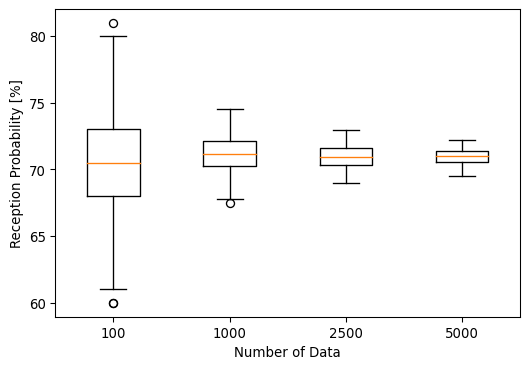

In [143]:
# Create a box plot
all_reception_prob = []

# define image properties
width = 600
height = 400
dpi = 96

fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)

for nb_sample in nb_sample_list:
    all_reception_prob.append(reception_prob_dict[nb_sample])

plt.boxplot(all_reception_prob)

plt.xlabel('Number of Data')
plt.ylabel('Reception Probability [%]')

plt.xticks(range(1, len(all_reception_prob) + 1), list(reception_prob_dict.keys()))

# Show the plot
plt.savefig('{}/boxplot_conv_traf_{}_range_{}.png'.format(path, traf_floor, range_floor), dpi = dpi)
plt.show()

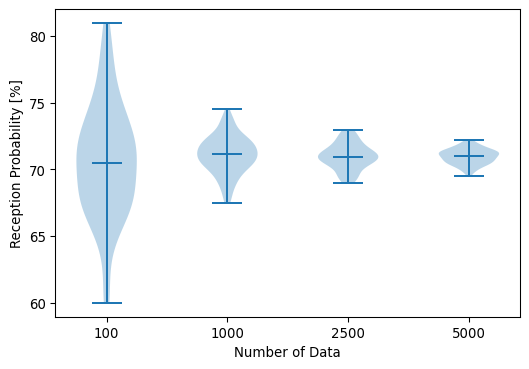

In [144]:
# Create a box plot
all_reception_prob = []

# define image properties
width = 600
height = 400
dpi = 96

fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)

for nb_sample in nb_sample_list:
    all_reception_prob.append(reception_prob_dict[nb_sample])

plt.violinplot(all_reception_prob,
               showmeans=False,
               showmedians=True)

plt.xlabel('Number of Data')
plt.ylabel('Reception Probability [%]')

plt.xticks(range(1, len(all_reception_prob) + 1), list(reception_prob_dict.keys()))

# Show the plot
plt.savefig('{}/violinplot_conv_traf_{}_range_{}.png'.format(path, traf_floor, range_floor), dpi = dpi)
plt.show()

In [145]:
mean_list = []
median_list = []
std_dev_list = []

for nb_sample in nb_sample_list:
    mean_list.append(np.mean(reception_prob_dict[nb_sample]))
    median_list.append(np.median(reception_prob_dict[nb_sample]))
    std_dev_list.append(np.std(reception_prob_dict[nb_sample]))

In [146]:
# Create a DataFrame with some sample data
data = pd.DataFrame({
    'nb_sample': nb_sample_list,
    'distribution': reception_prob_dict.values(),
    'mean': mean_list,
    'median': median_list,
    'std_dev': std_dev_list
})

data

,nb_sample,distribution,mean,median,std_dev
0,100,"[72.00000000000004, 65.00000000000003, 67.0000...",70.6000,70.50,4.230839
1,1000,"[70.50000000000006, 73.00000000000006, 71.0000...",71.0860,71.15,1.419015
2,2500,"[70.95999999999871, 70.91999999999872, 69.5999...",70.9708,70.94,0.954163
3,5000,"[70.97999999999544, 70.71999999999548, 70.8599...",70.9680,70.99,0.575590


## Save Results

In [147]:
path = '../results/convergence_analysis'
os.makedirs(path, exist_ok=True)

data.to_json('{}/convergence_test_traf_{}_range_{}.json'.format(path, traf_floor, range_floor))

## Conclusion

With 2500 data points, we get a standard deviation of 0.9, we can expect that the majority of the values in our dataset will fall within approximately 0.9 units above or below the mean of 70.9.

So, the shape is roughly a normal distribution, about 68% of the values would fall within the range of 70.0 to 71.8, about 95% would fall within the range of 69.1 to 72.7, and about 99.7% would fall within the range of 68.2 to 73.6.